# Scrape data from USNEWS to see why Top30 universities are Top30

#### Group Members: Jonathan Dygert (jdygert), Lizhou Wang (wlizhou1), Haizhou Li (hydro98)

Every year, USNEWS provides us the top universities in the United States and we want to know the differences between normal universities and the best colleges.

What makes the top 30 universities the best?

USNews ranks US universities based on a lot of data pertaining to each university.

We will want to figure out what the best univiersities have in common, as well as any trends that occur such as correlations between rank and some other information.

In [1]:
import requests
import bs4
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering Data

In [2]:
headers = {"user-agent": "Mozilla/5.0"}
base = "https://www.usnews.com/best-colleges/"

First, we manually loaded the page https://www.usnews.com/best-colleges/rankings/national-universities in a browser. This is a search page that loads more results when scrolling. We noticed that many of the lower ranked universities were missing information, so we decided to only look at the top 150 universities.

We used this page to extract a list of IDs for the universities that we wanted to gather information about.

In [3]:
with open("colleges.html", encoding="latin1") as f:
    soup = bs4.BeautifulSoup(f)

colleges = [tag["href"][37:] for tag in soup.find_all("a", {"class": "card-name"})[:150]]

Now we can scape data about each college. The pages are mostly in the same format, so we can just look for the target description text and the field is usually in the next sibling. We describe these simple targets that we can get from various pages in a dictionary. The academics page has graphs and is harder to scrape, so we scrape these seperately along with the college name.

In [4]:
simpleTargets = {
    "rankings": [
        ("OverallScore", "Score"),
        ("SixYearGraduationRate", "Average 6-year graduation rate (17.6%)"),
        ("StudentFacultyRatio", "Student-faculty ratio (1%)"),
    ],
    "student-life": [
        ("TotalEnrollment", "Total enrollment"),
        ("UndergraduateEnrollment", "Total undergraduate enrollment"),
        ("GraduateEnrollment", "Total graduate enrollment"),
        ("FirstGenerationUndergraduate", "Undergraduates who are first generation"),
    ],
    "paying": [
        ("TuitionAndFees", "Tuition and fees"),
        ("InStateTuitionAndFees", "In-state tuition and fees"),
        ("OutOfStateTuitionAndFees", "Out-of-state tuition and fees"),
        ("AverageAnnualCost", "Average annual cost"),
        ("RoomAndBoard", "Room and board"),
    ],
    "applying": [
        ("ApplicationFee", "Application fee"),
        ("AcceptanceRate", "Acceptance rate"),
    ],
    "campus-info": [
        ("CampusSize", "Campus size (acres)"),
        ("AlcoholPermission", "Alcohol permitted on campus for students of legal age"),
    ],
}

In [5]:
simpleFields = [f for _, fs in simpleTargets.items() for f, _ in fs]
academicFields = ["FullTimeFacultyMale", "PartTimeFacultyMale", "ClassSizeUnder20", "ClassSize20To50", "ClassSizeOver50"]

data = pd.DataFrame(columns=["Id", "Name"] + simpleFields + academicFields)
data.Id = colleges

for i, college in enumerate(colleges):
    url = base + college + "/academics"
    page = requests.get(url, headers=headers)
    soup = bs4.BeautifulSoup(page.text, 'html5lib')
    
    data.loc[i, "Name"] = soup.find("h2").text

    data.loc[i, "FullTimeFacultyMale"] = soup.find("p", text="Full-time faculty gender distribution").next_sibling.find(text="Male").next_sibling.text
    data.loc[i, "PartTimeFacultyMale"] = soup.find("p", text="Part-time faculty gender distribution").next_sibling.find(text="Male").next_sibling.text
    
    sizes = soup.find("p", text="Class sizes").next_sibling
    data.loc[i, "ClassSizeUnder20"] = sizes.find(text="Classes with fewer than 20 students").next_sibling.text
    data.loc[i, "ClassSize20To50"] = sizes.find(text="20-49").next_sibling.text
    data.loc[i, "ClassSizeOver50"] = sizes.find(text="50 or more").next_sibling.text

    for section, fields in simpleTargets.items():
        url = base + college + "/" + section
        page = requests.get(url, headers=headers)
        soup = bs4.BeautifulSoup(page.text)
        for field, text in fields:
            p = soup.find("p", text=text)
            span = soup.find("span", text=text)
            if p is not None:
                data.loc[i, field] = p.next_sibling.text
            elif span is not None:
                data.loc[i, field] = span.parent.parent.parent.next_sibling.text

Finally, we clean the data by removing percents, commas, dollar signs, ratios, and years.

In [6]:
for field in ["SixYearGraduationRate", "AcceptanceRate", "FirstGenerationUndergraduate"] + academicFields:
    data[field] = data[field].str.replace("%", "")

data.StudentFacultyRatio = data.StudentFacultyRatio.apply(lambda s: s[:-2])

for field in ["TuitionAndFees", "InStateTuitionAndFees", "OutOfStateTuitionAndFees", "AverageAnnualCost", "RoomAndBoard", "ApplicationFee"]:
    data[field] = data[field].str.replace(",", "")
    data[field] = data[field].str.replace(r"^\$?(\d+).*$", r"\1")

for field in ["TotalEnrollment", "UndergraduateEnrollment", "GraduateEnrollment", "CampusSize"]:
    data[field] = data[field].str.replace(",", "")

data.to_csv("data.csv", index=False)

# Analysis

In [7]:
data = pd.read_csv("data.csv")

Basic data

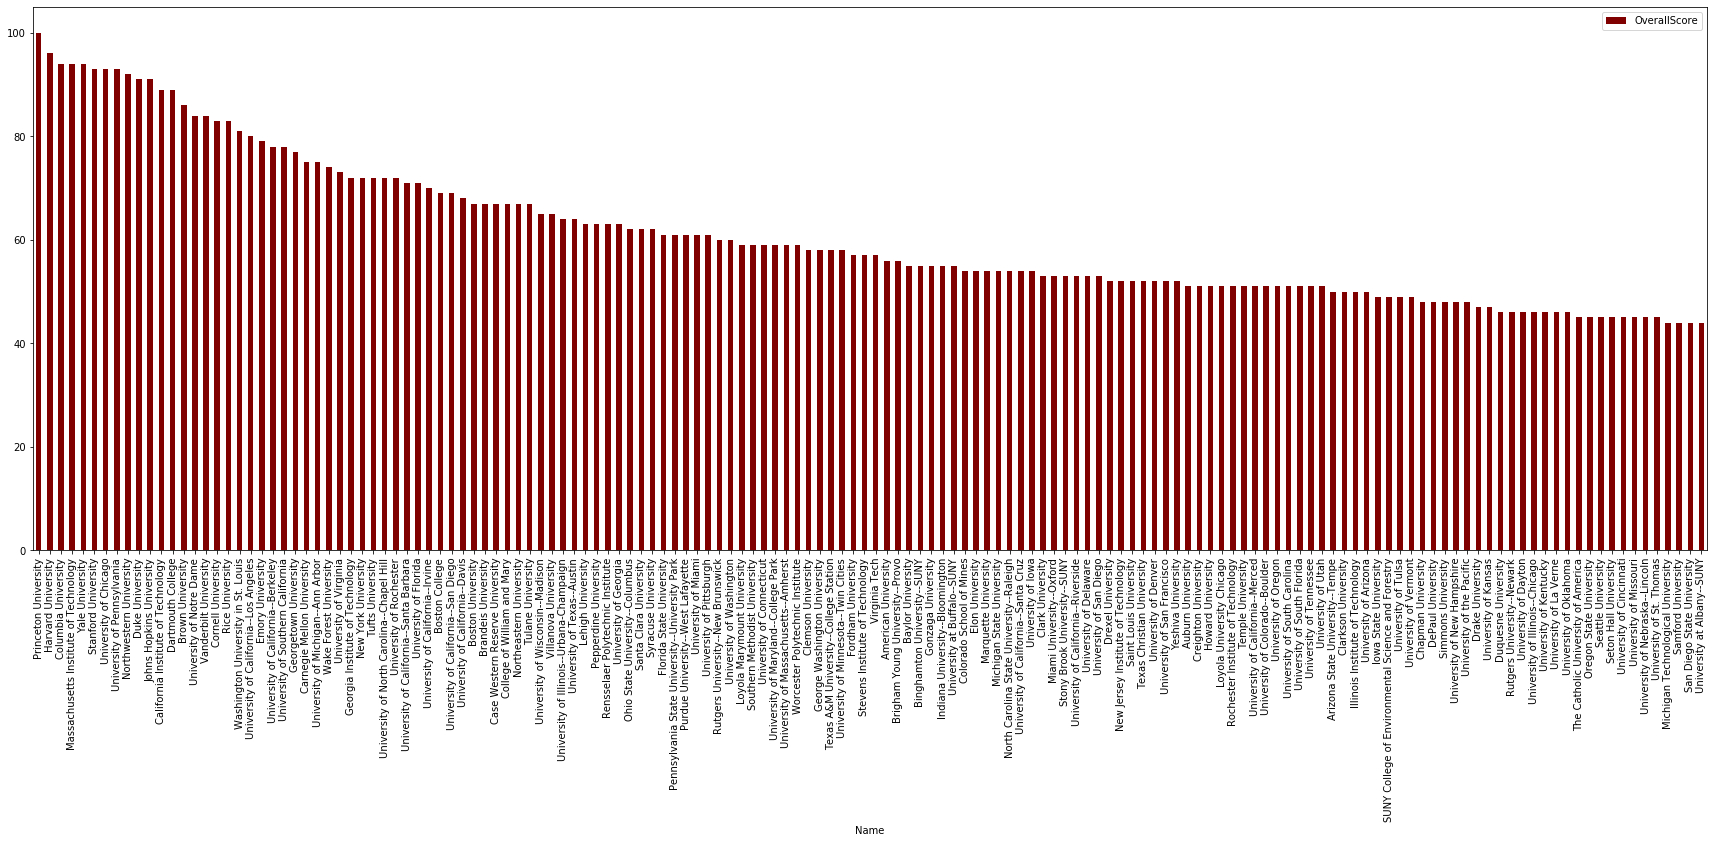

In [8]:
data.plot.bar(x = 'Name', y = 'OverallScore', figsize = (30, 10), color = 'maroon')

We can look at the correlation matrix for the data to look for interesting correlations that we should investigate further.

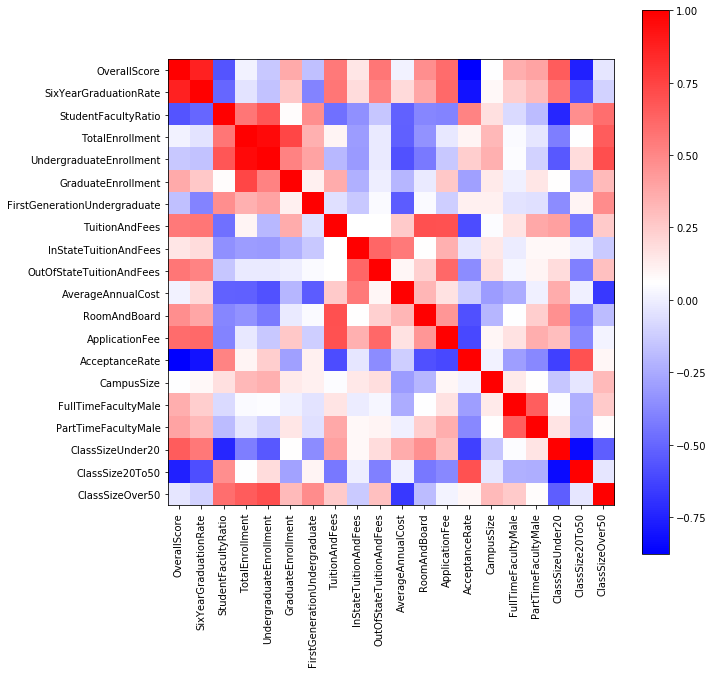

In [9]:
corr = data.corr()
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap="bwr")
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns, rotation=90)
plt.yticks(range(len(corr)),corr.index);

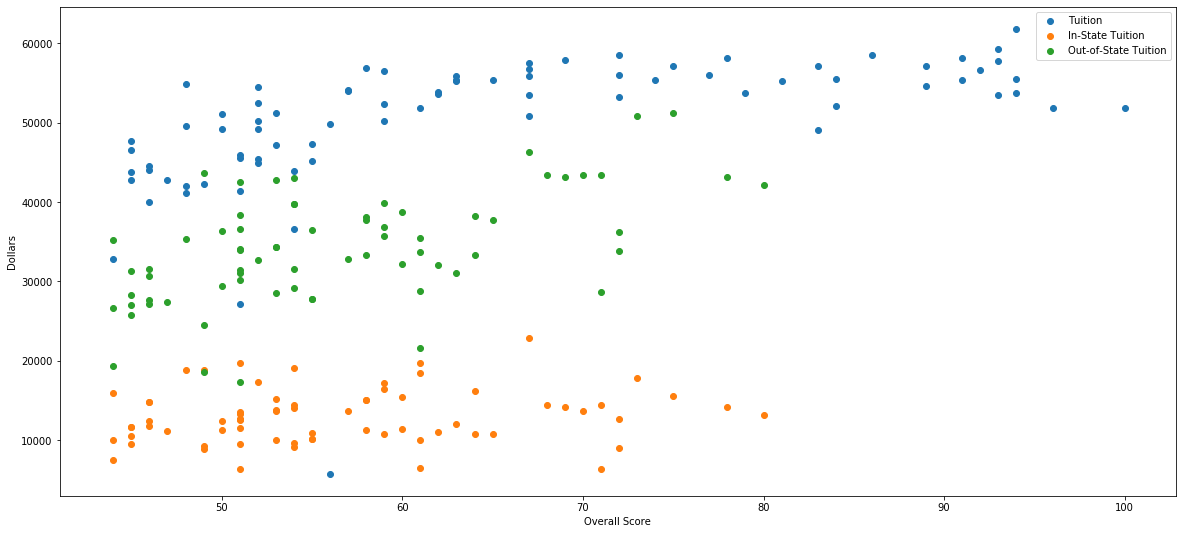

In [10]:
_, ax = plt.subplots(figsize=(20, 9))
ax.scatter(data.OverallScore, data.TuitionAndFees, label="Tuition")
ax.scatter(data.OverallScore, data.InStateTuitionAndFees, label="In-State Tuition")
ax.scatter(data.OverallScore, data.OutOfStateTuitionAndFees, label="Out-of-State Tuition")
ax.set_xlabel("Overall Score")
ax.set_ylabel("Dollars")
ax.legend();

We can see some interesting general facts here. Colleges that do not split tuition into in-state and out-of-state generally have a higher tuition. Out-of-state tuition is, of course, higher than in-state tuition. The top group of schools all do not split their tuition, and have similar, high tuitions.

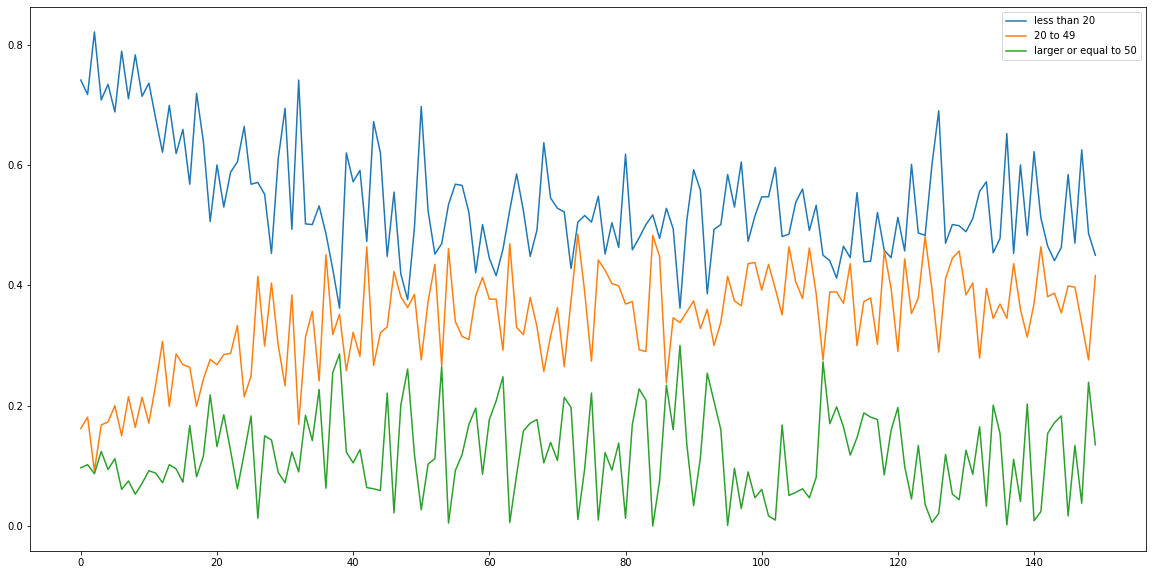

In [15]:
data1 = pd.read_csv('Project1_ProjectGroup7.csv')
# data.columns


lessThan20 = [data1.ClassSize.iloc[i].split(':')[0] for i in range(len(data1.ClassSize))]
lessThan20 = [float(lessThan20[i].strip().strip('%'))/100 for i in range(len(data1.ClassSize))]
lessThan20 = pd.DataFrame({'Name': data1.Name,'Data': lessThan20})

twenty_to_49 = [data1.ClassSize.iloc[i].split(':')[1] for i in range(len(data1.ClassSize))]
twenty_to_49 = [float(twenty_to_49[i].strip().strip('%'))/100 for i in range(len(data1.ClassSize))]
twenty_to_49 = pd.DataFrame({'Name': data1.Name,'Data': twenty_to_49})

largerequal50 = [data1.ClassSize.iloc[i].split(':')[2] for i in range(len(data1.ClassSize))]
largerequal50 = [float(largerequal50[i].strip().strip('%'))/100 for i in range(len(data1.ClassSize))]
largerequal50 = pd.DataFrame({'Name': data1.Name,'Data': largerequal50})

plt.plot(lessThan20.Data)
plt.plot(twenty_to_49.Data)
plt.plot(largerequal50.Data)
plt.legend(('less than 20', '20 to 49', 'larger or equal to 50'))
plt.rcParams["figure.figsize"] = [40, 20]

from this plot, we can see that as the rank of schools dropping, the number of class with size less than 20 is decrease, 20 to 49 is increasing. Since small size class makes professors easier to know more about their students, it makes sence that those high-ranking schools have more small size classes.

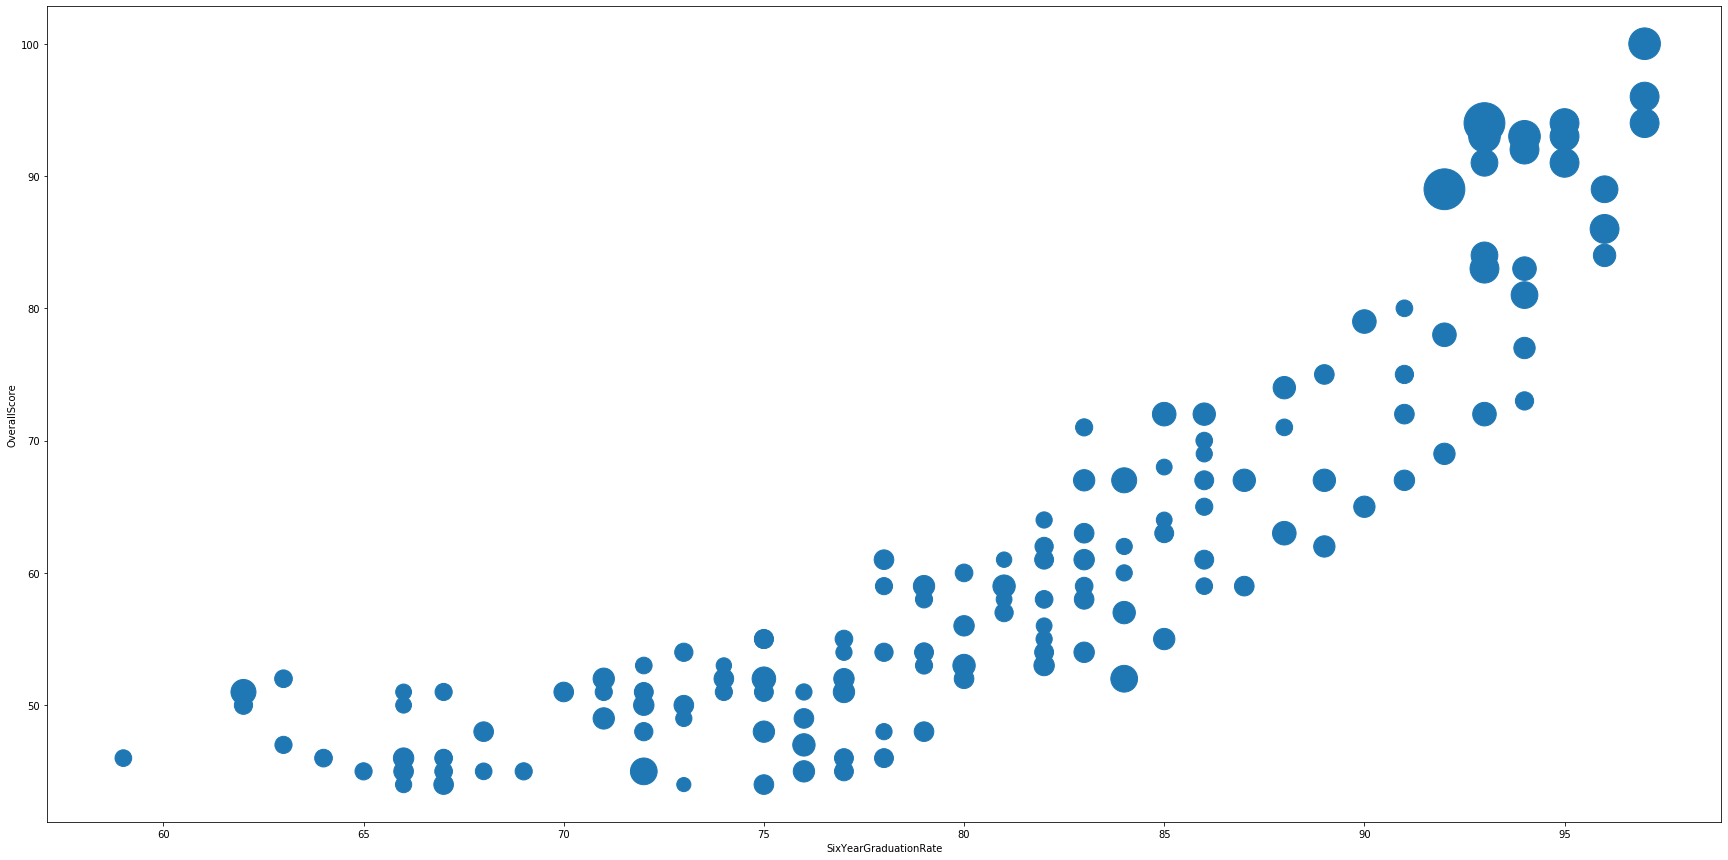

In [12]:
data.plot.scatter(x='SixYearGraduationRate',y='OverallScore',s=5000/data.StudentFacultyRatio,figsize=(30, 15))

By using this scatter plot, the size of the dot represents the student faculty ratio, if the dot is larger, then the student faculty ratio is lower, and the x-axis is the six-year graduation rate and the y-axis is the university overall score. It's easily to see that the universities with higher overall score also have less student faculty ratio and larger six-year graduation rate.

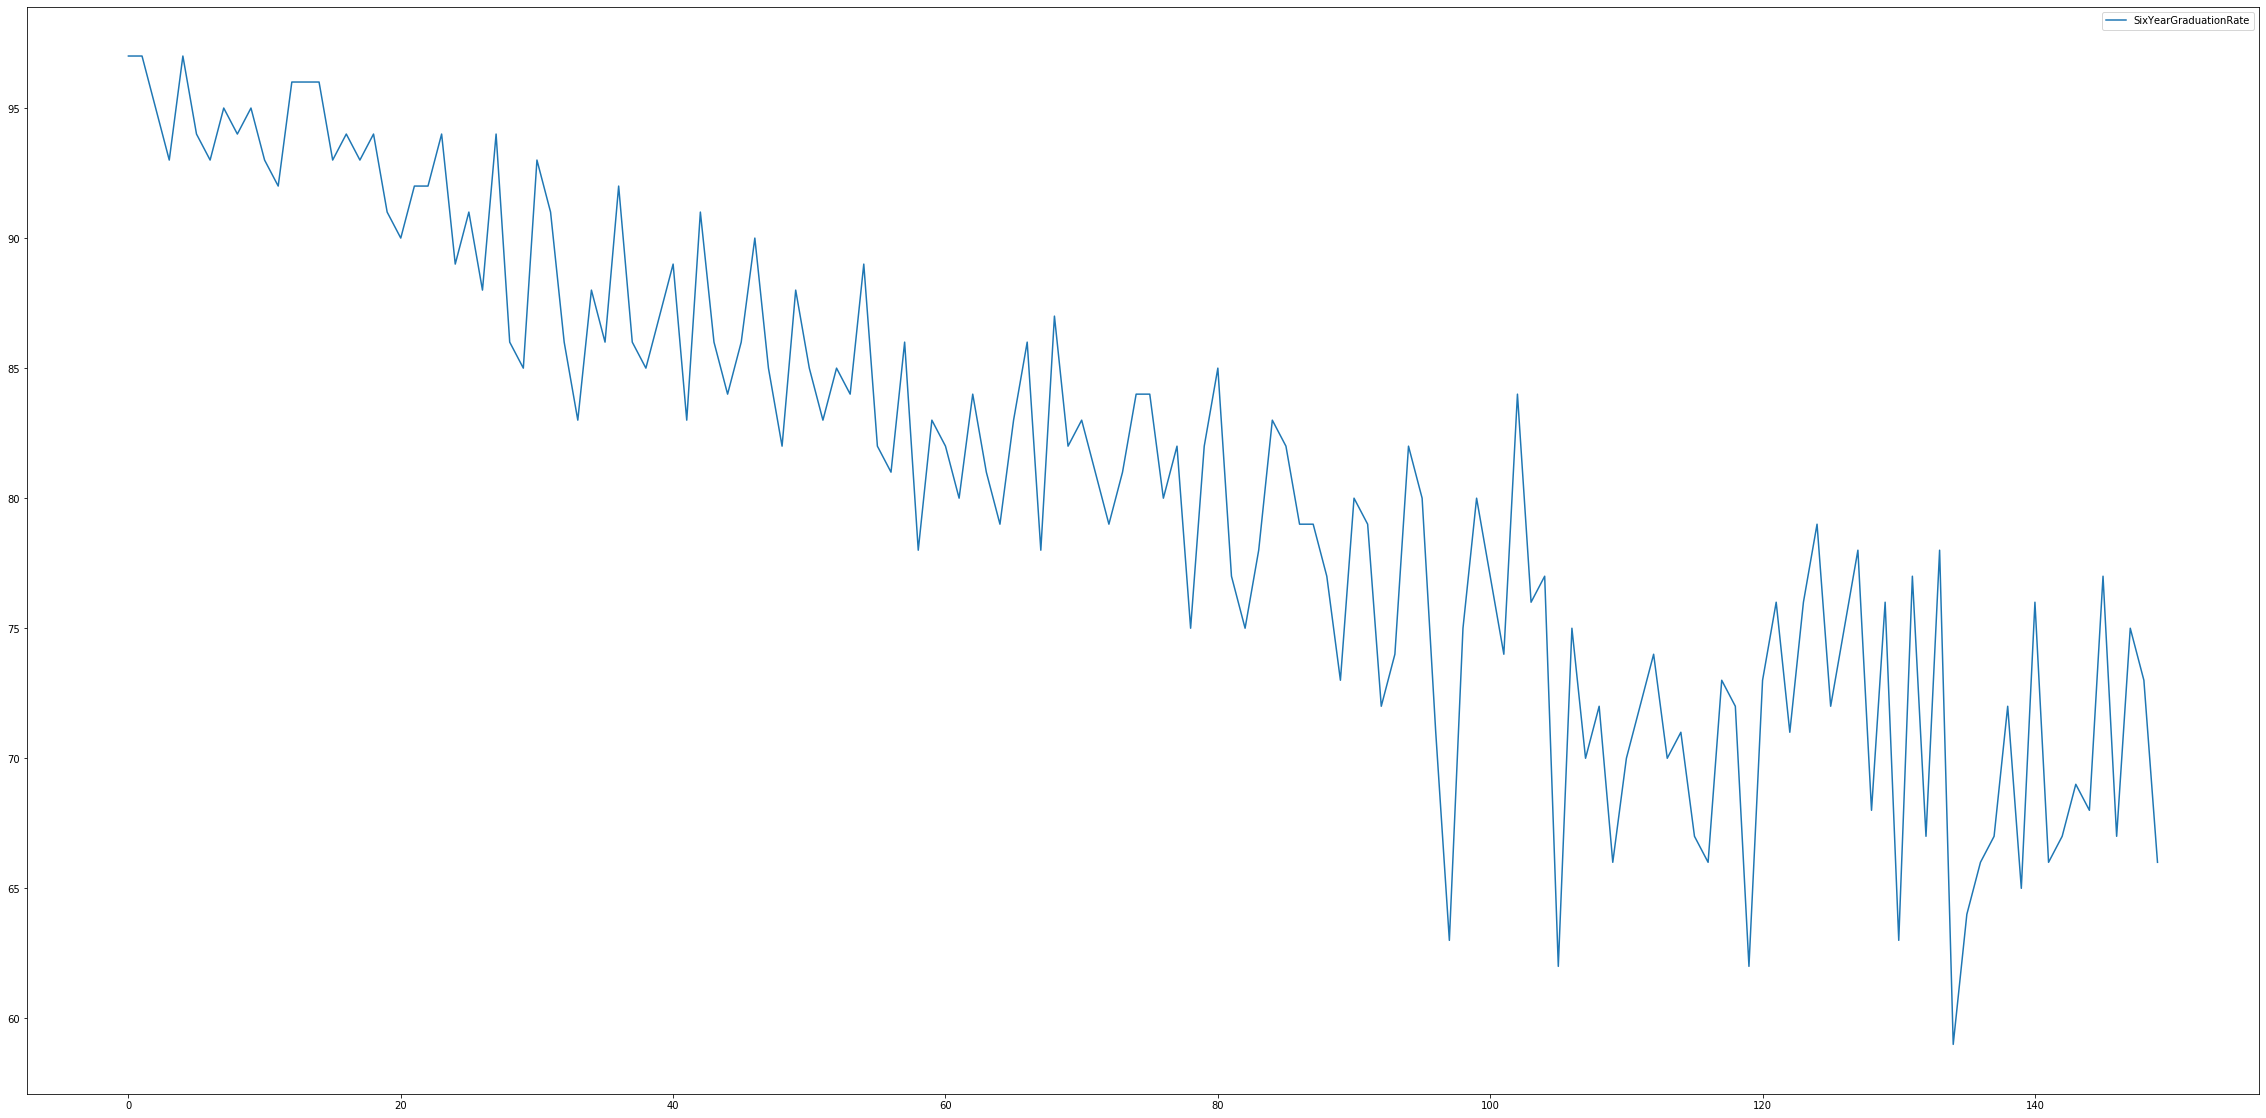

In [16]:
plt.plot([int(data1.SixYearGraduationRate.iloc[i].strip('%')) for i in range(len(data1.SixYearGraduationRate))])
plt.legend(['SixYearGraduationRate'])

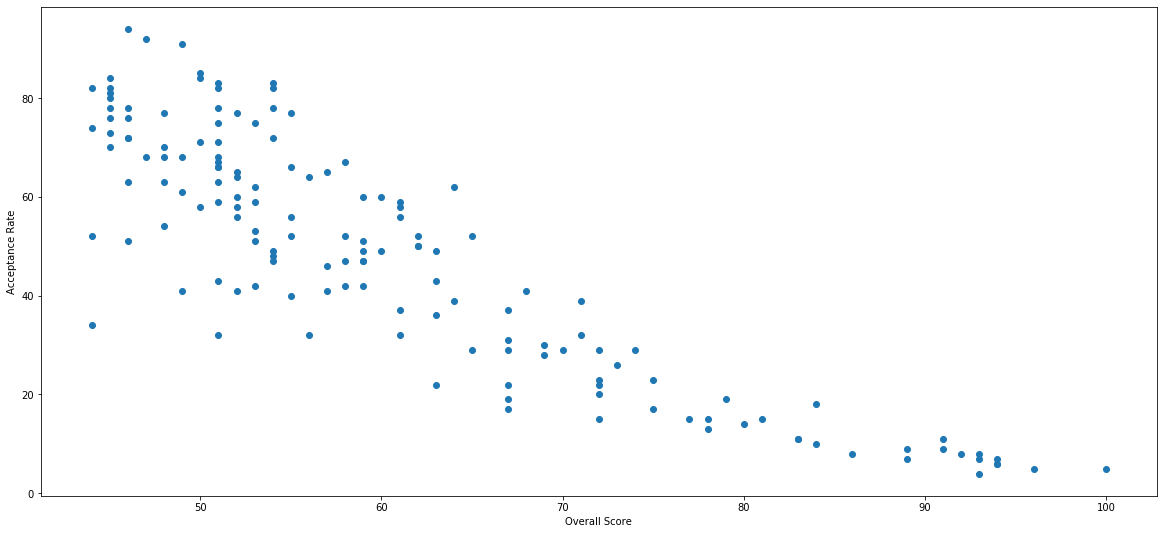

In [13]:
_, ax = plt.subplots(figsize=(20, 9))
ax.scatter(data.OverallScore, data.AcceptanceRate)
ax.set_xlabel("Overall Score")
ax.set_ylabel("Acceptance Rate");

When students apply for the school, acceptance rate is one of the most important data to compare, and we found that the universities with higher scores have lower acceptance rate

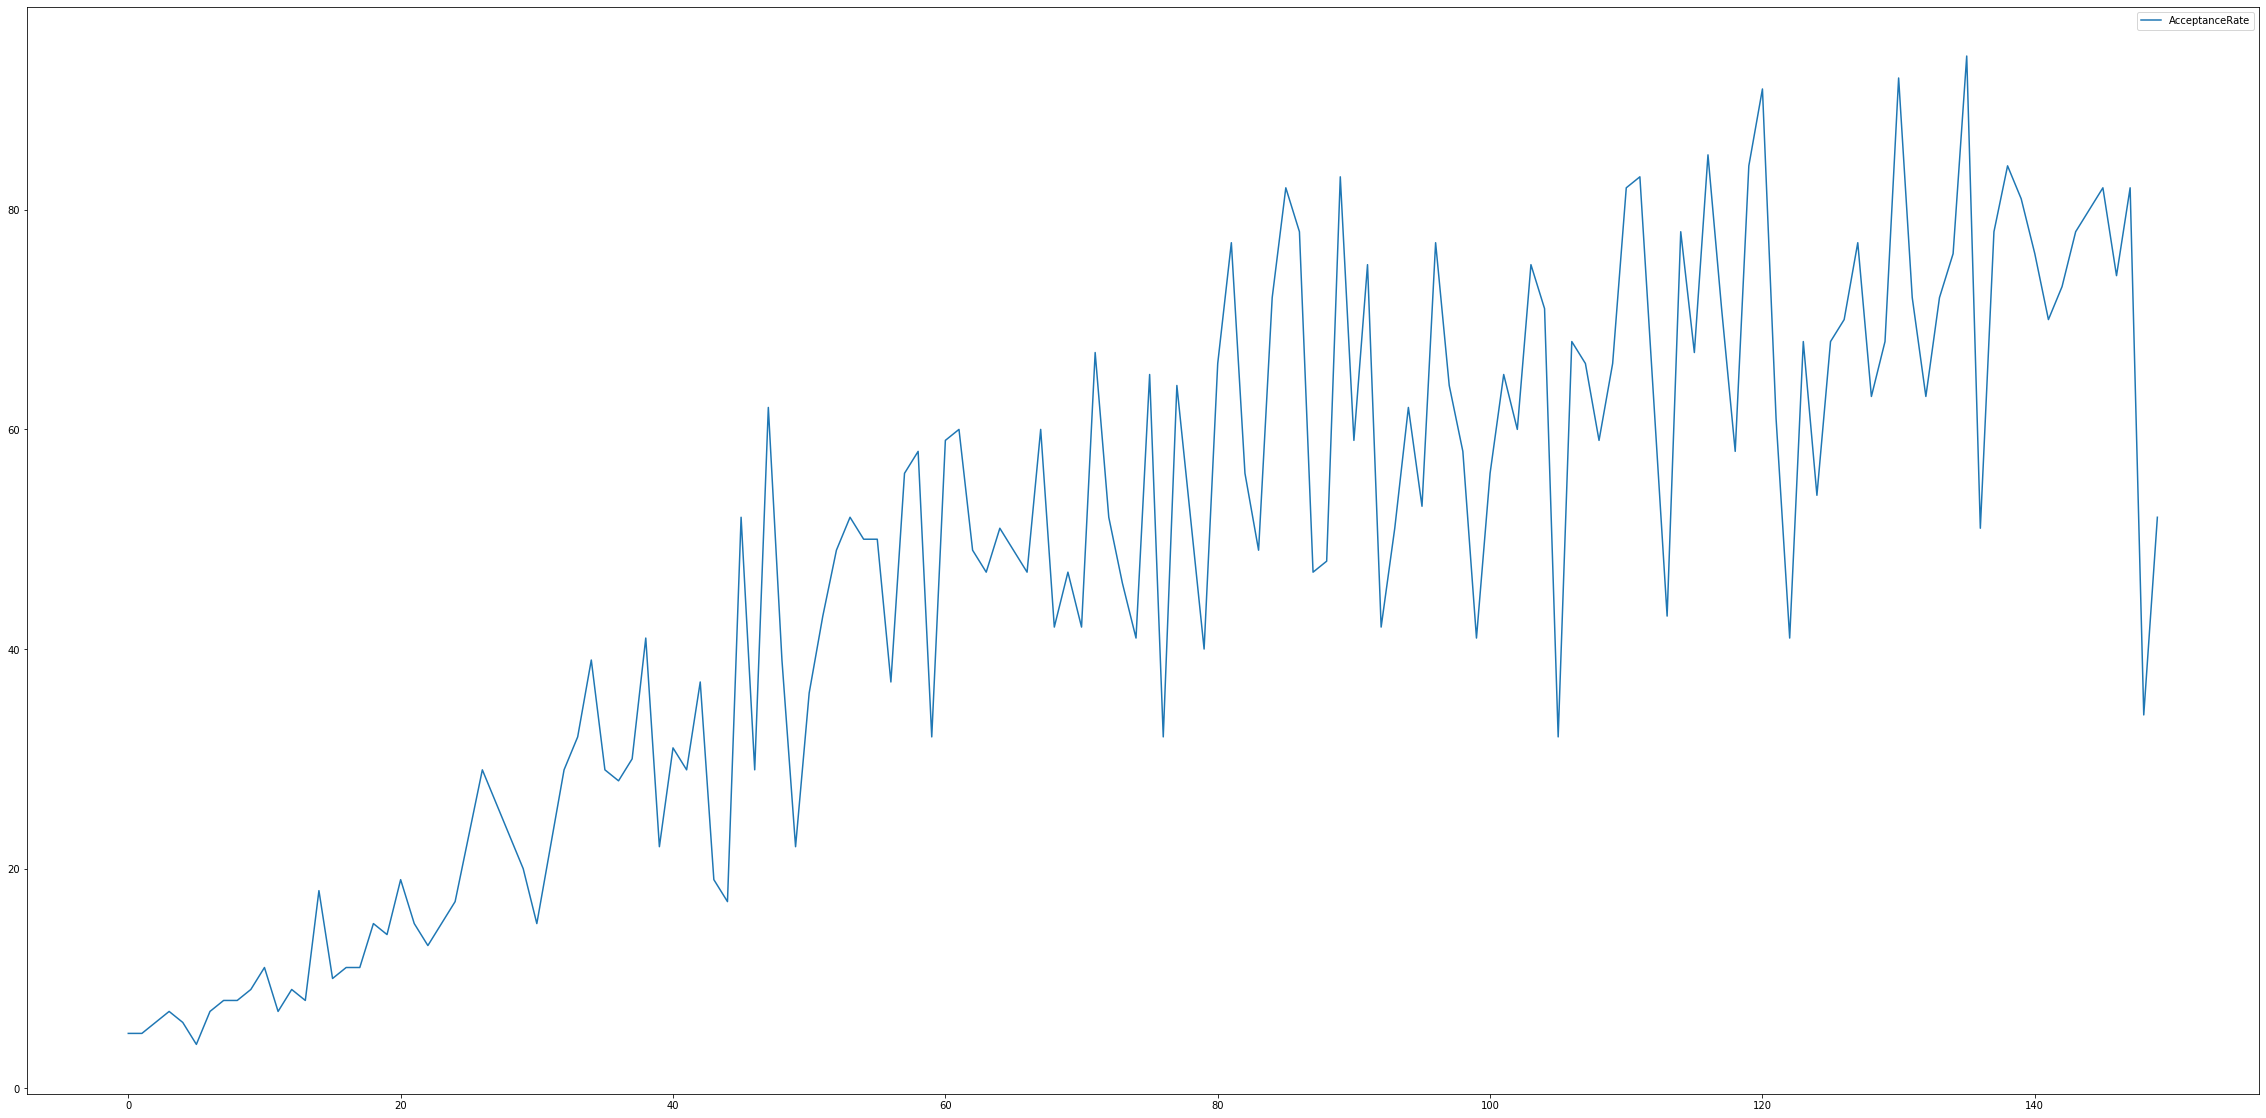

In [17]:
plt.plot([int(data1.AcceptanceRate.iloc[i].strip('%')) for i in range(len(data1.AcceptanceRate))])
plt.legend(['AcceptanceRate'])

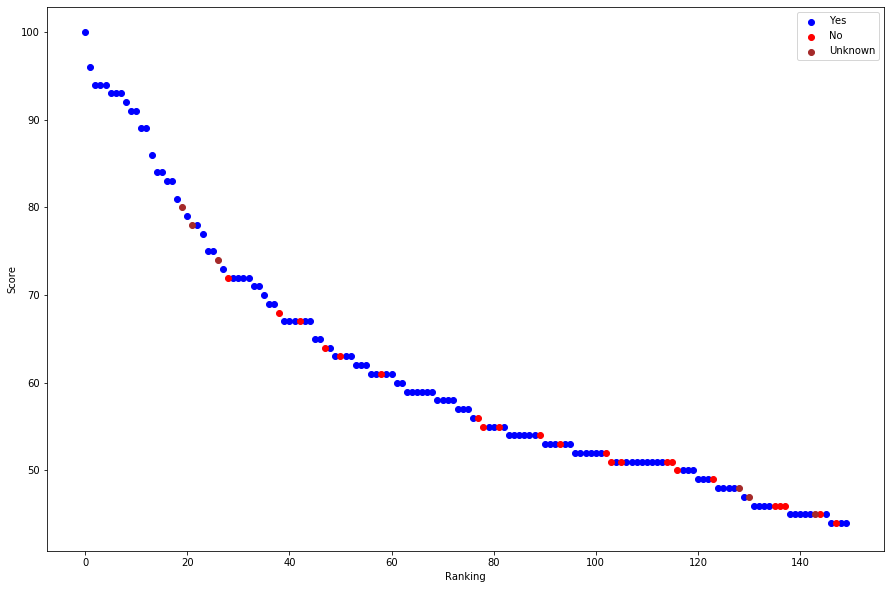

In [14]:
_, ax = plt.subplots(figsize=(15, 10))

yes = data[data.AlcoholPermission == "Yes"]
ax.scatter(yes.index, yes.OverallScore, c="blue", label="Yes")

no = data[data.AlcoholPermission == "No"]
ax.scatter(no.index, no.OverallScore, c="red", label="No")

unknown = data[data.AlcoholPermission.isnull()]
ax.scatter(unknown.index, unknown.OverallScore, c="brown", label="Unknown")

ax.set_xlabel("Ranking")
ax.set_ylabel("Score")
ax.legend();

Interestingly, allowing alcohol on campus seems to not have much of an impact on the ranking of a school.

# Conclusion

Overall, our findings seemed to make sense. We found that great universities with high overall scores have high six-year gradutation rates, high tuition, low student-faculty ratios, low acceptance rate, and small classes. We also found out that prohibiting alcohol on campus has little effect on a school's ranking.

In future work, it could be interesting to look at a lot of additional factors for the universities such as student clubs, percentages for different majors, results after graduation, fraternities, greek life, and demographics. Additionally, it would be nice to find a large sample of student reviews of the universities, in which we could persue text analysis.

## Credits

#### Jonathan Dygert
- Helped scrape data
- Cleaned input data
- Provided correlation visual
- Provided tuition visual and analysis

#### Lizhou Wang
- Helped scrape data
- Created some visualizations
- Provided some analysis

#### Haizhou Li
- Helped scrape data
- Created some visualizations
- Provided some analysis